# EDA, Label creation, Data prep

In this notebook I visually explored the data, created labels for each row to indicate if the customer should buy now (1), wait or buy (0), or wait (-1) according to all of the historical data, and I prepped the data for the machine learning model. 

### Importing modules:

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Importing the data:

In [8]:
df = pd.read_csv('../boscun-longitudinal.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009408 entries, 0 to 3009407
Data columns (total 26 columns):
search_id                       object
trip_index                      int64
received_date                   object
received_ms                     int64
origin                          object
destination                     object
total_usd                       float64
pax_type                        object
refundable                      float64
validating_carrier              object
departure_odate                 object
departure_ms                    int64
outgoing_duration               int64
outgoing_stops                  int64
return_odate                    object
return_ms                       int64
returning_duration              int64
returning_stops                 int64
major_carrier_id                object
total_stops                     int64
advance                         int64
length_of_stay                  int64
includes_saturday_night_stay    bool
a

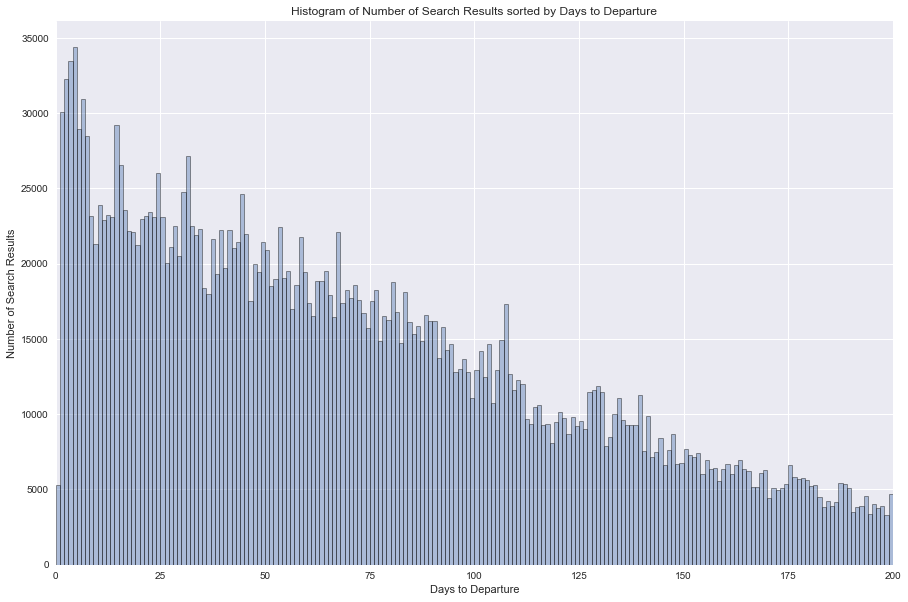

In [10]:
df['departure_dow'] = pd.to_datetime(df['departure_odate']).dt.weekday
sns.set()
bins =351
_ = plt.figure(figsize = (15,10))
_ = sns.distplot(df['advance'], bins, hist_kws=dict(edgecolor="k", linewidth=1), kde = False)
_ = plt.title("Histogram of Number of Search Results sorted by Days to Departure")
_ = plt.ylabel("Number of Search Results")
_ = plt.xlabel("Days to Departure")
_ = plt.xlim(0,200)

The histogram above seems to indicate some sort of weekly oscillation in the number of searches. This was surprising to me because the days to departure represents any day of the week, because this dataset is a collection of many different travel dates. This is probably due to the fact that there are weekly oscillatory patterns in both search day of week and departure day of week, and those patterns are not totally neutralized when they are subtracted to get days to departure. 

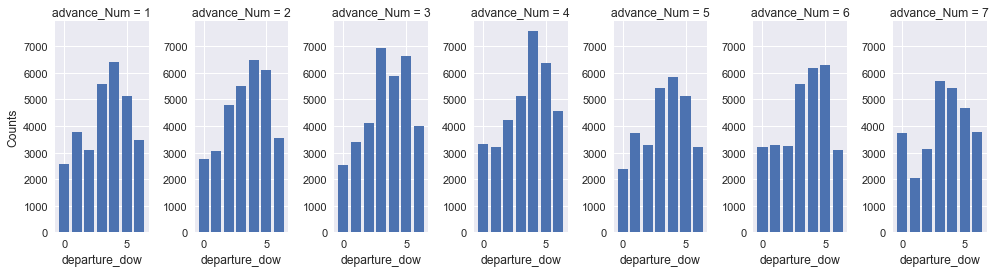

In [11]:
sns.set(font_scale =1.5)
advance_7day = df[(df['advance'] >= 1)&(df['advance'] <= 7)]
# First I focused on one single 7 day cycle. This is from 1 DTD to 7 DTD.
advance_Num = []
DepartureDOW = []
Counts = []
for i in np.arange(1,8):
    DTD = advance_7day[advance_7day['advance'] == i]
    DTD = DTD['departure_dow'].value_counts().reset_index()
    DTD.columns = ['departure_dow', 'Counts']
    DTD['advance_Num'] = i
    advance_Num.extend(DTD['advance_Num'])
    DepartureDOW.extend(DTD['departure_dow'])
    Counts.extend(DTD['Counts'])
DTD_plot = pd.DataFrame()
DTD_plot['advance_Num'] = advance_Num
DTD_plot['departure_dow'] = DepartureDOW
DTD_plot['Counts'] = Counts
sns.set(font_scale = 1.1)
g = sns.FacetGrid(DTD_plot, col='advance_Num', size=4, aspect=.5)
g = (g.map(plt.bar, 'departure_dow', 'Counts'))
#plt.savefig(r"C:\Users\elise.held\Desktop\Figure2.png", bbox_inches='tight')

The count plots above show the weekly pattern of departure day of week in the last 7 days before departure. It isn't surprising that the highest bars are 3, 4, and 5 (Thursday, Friday, Saturday).

In [12]:
df['search_dow'] = pd.to_datetime(df['received_date']).dt.weekday

In [13]:
lens = []
ns = []
ms = []
for n in np.arange(1,8):
    for m in np.arange(1,8):
        x = len(df[(df['search_dow'] == n -1)&(df['departure_dow'] == m-1)])
        lens.append(x)
        ns.append(n)
        ms.append(m)

In [14]:
srch_dep_dow = pd.DataFrame({'Counts': lens, 'Search DOW' : ns, 'Departure DOW' : ms})

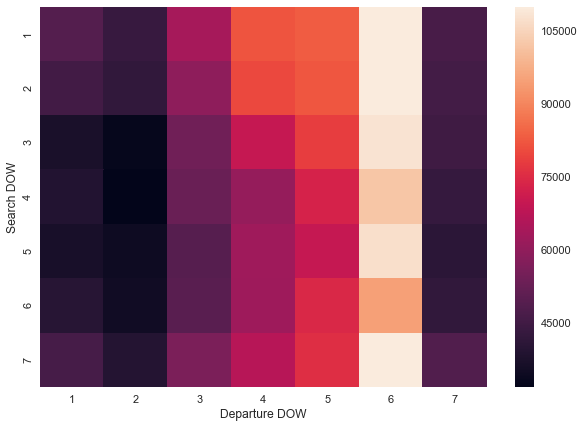

In [15]:
srch_dep_dow = srch_dep_dow.pivot("Search DOW", "Departure DOW", "Counts")
_ = plt.figure(figsize = (10,7))
_ = sns.heatmap(srch_dep_dow)

This heat map again explores the relationship between search day of week and departure day of week.

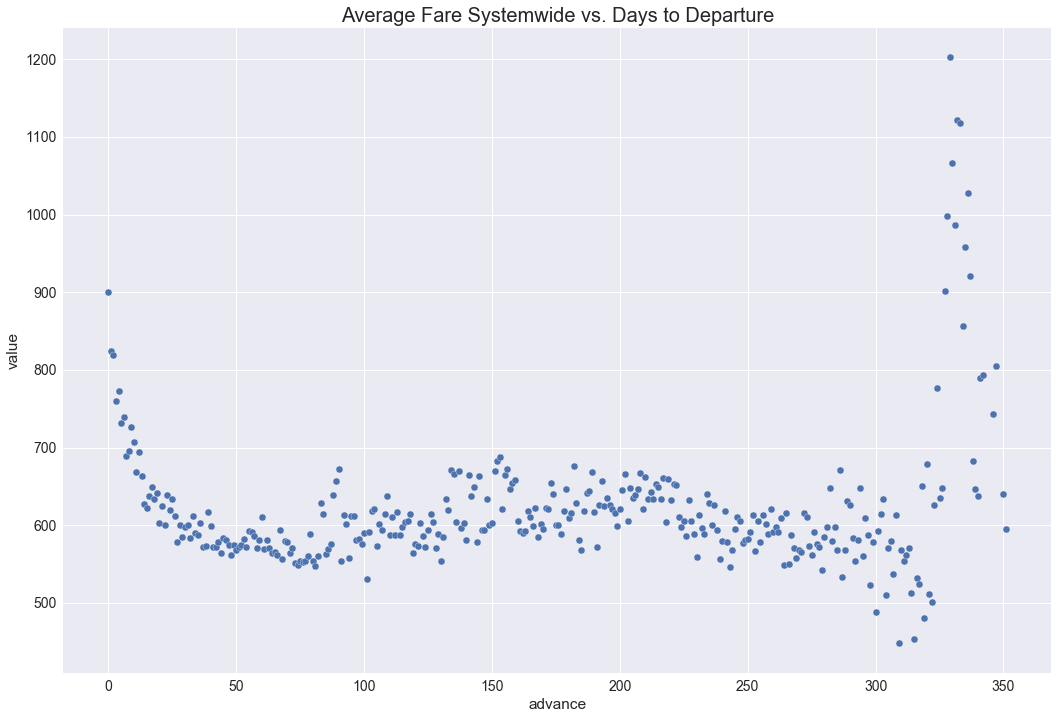

In [16]:
DTD_Fare = df.groupby(['advance'])['total_usd'].mean().reset_index()
DTD_Fare = DTD_Fare.melt(id_vars = ['advance'])

sns.set(font_scale = 1.4)
#g = sns.FacetGrid(DTD_Fare,  hue="variable", size = 10, aspect = 1.5, xlim = (-2,122), ylim = (0,300), hue_kws=dict(marker=["o", "o"], color=['blue','red'], s = [100,100]))
g = sns.FacetGrid(DTD_Fare, size = 10, aspect = 1.5)
g = (g.map(plt.scatter, "advance", "value", edgecolor="w"))
_ = plt.title('Average Fare Systemwide vs. Days to Departure', fontsize = 20)

This scatter plot shows the relationship between the fare in USD and the days before departure. It is a bit suprising to me that this relationship isn't more inversely linear. I know from my experience at Frontier, however, that around the range between 50 and 100 days before departure we often have to drop our fares lower than they were before in order to increase load factor.

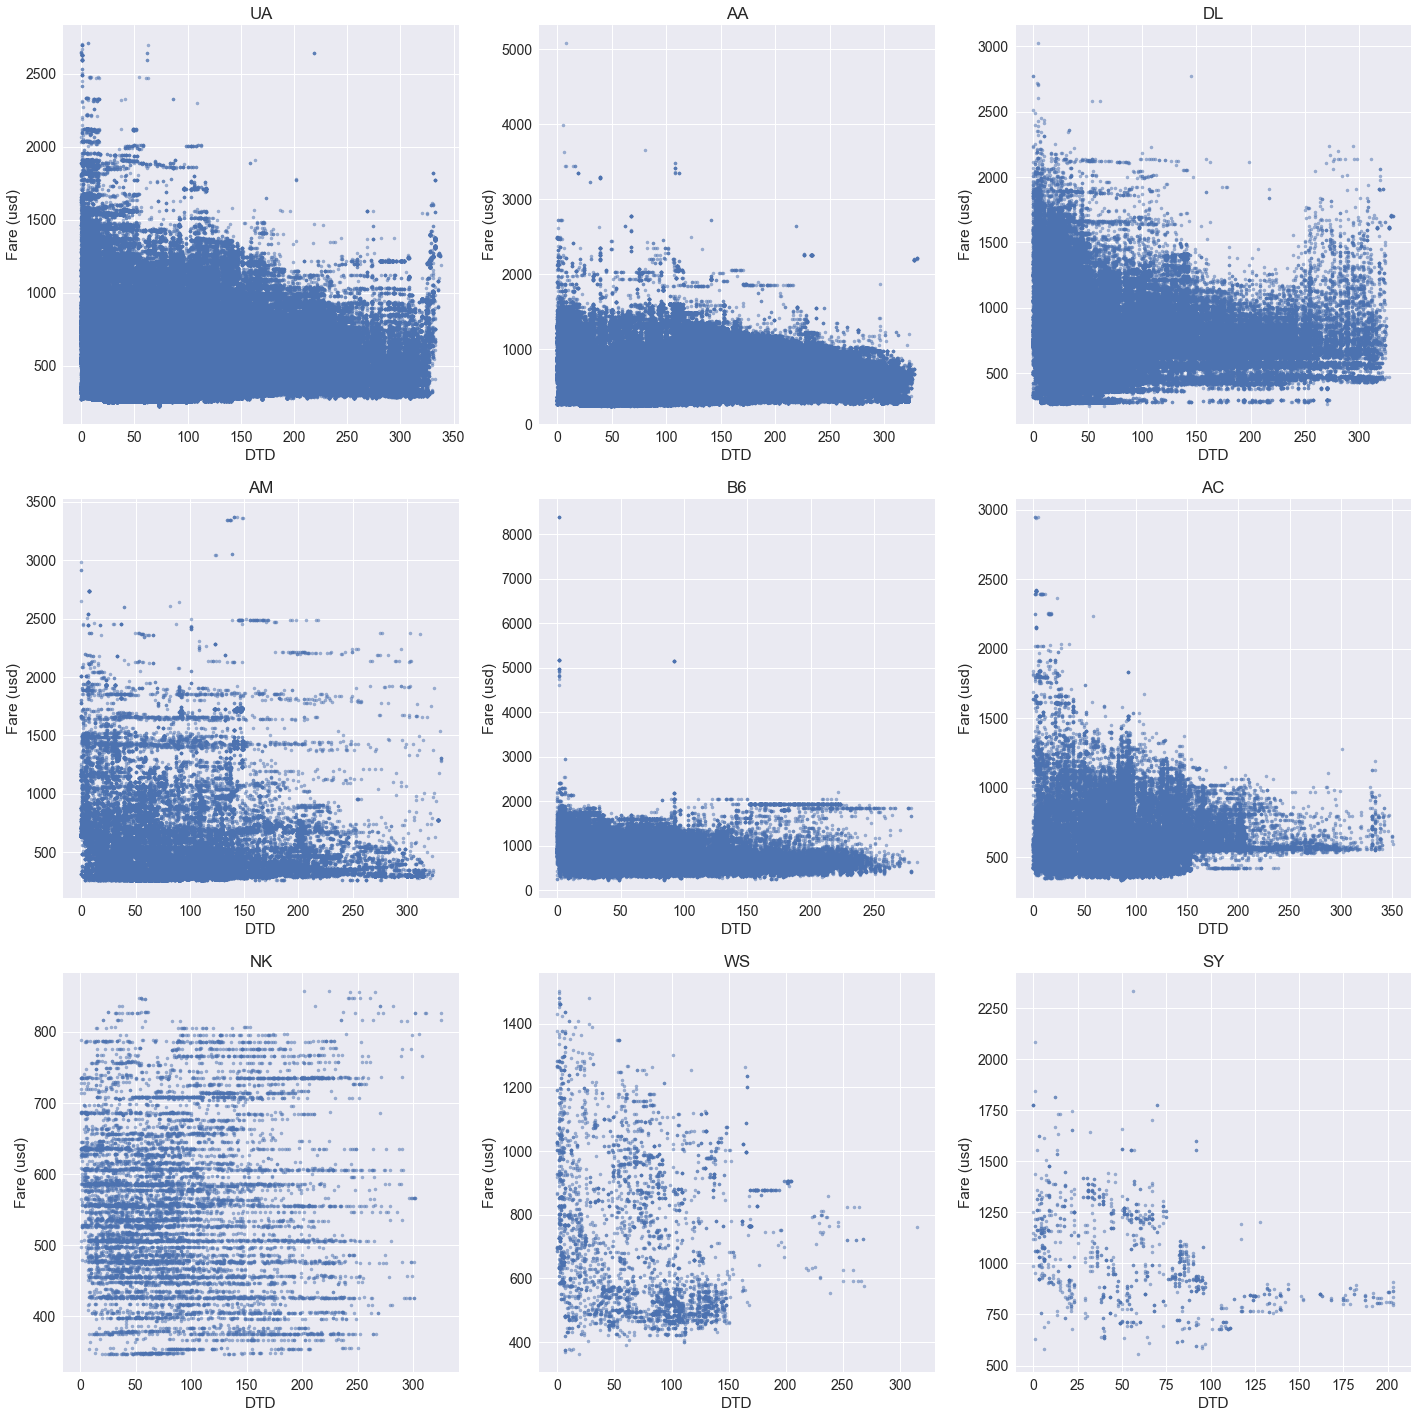

In [17]:
cxr = np.array(df['validating_carrier'].value_counts().reset_index()['index'])
s = 10
alpha = 0.5

_ = plt.figure(figsize = (20,20))
for c, n in zip(cxr, np.arange(1,10)):
    _ = plt.subplot(3,3, n)
    _ = plt.scatter(df[df['validating_carrier'] == c]['advance'], df[df['validating_carrier'] == c]['total_usd'], s = s, alpha = alpha)
    _ = plt.xlabel('DTD')
    _ = plt.ylabel('Fare (usd)')
    _ = plt.title(c)
    _ = plt.tight_layout()

These scatter plots show the relationship between fare in USD and days to departure for each of the top 9 highest occuring carriers in this dataset. It is no suprise to me that the legacy carriers (United, American, Air Canada), have very clear relationships between fare and DTD. As DTD gets smaller, the fare goes up. These airlines have the freedom to maintain this relationship because they do not depend on ancillary revenue as much as low cost carriers like Spirit. If Spirit isn't selling enough tickets on a certain flight, they are forced to drop their fares in order to increase load factor, so they can still get the ancillary revenue. 

In [ ]:
len_s = np.array(df['length_of_stay'].value_counts().reset_index()['index'])

In [ ]:
len_s = np.array(df['length_of_stay'].value_counts().reset_index()['index'])
s = 10
alpha = 0.5

_ = plt.figure(figsize = (20,20))
for l, n in zip(len_s, np.arange(1,10)):
    _ = plt.subplot(3,3, n)
    _ = plt.scatter(df[df['length_of_stay'] == l]['advance'], df[df['length_of_stay'] == l]['total_usd'], s = s, alpha = alpha)
    _ = plt.xlabel('Advance')
    _ = plt.ylabel('Fare (usd)')
    _ = plt.title(l.astype(str) + ' Days')
    _ = plt.tight_layout()

These scatter plots show the relationship between days to departure (advance) and length of stay. These are very surprising to me because in my experience, airlines are no longer pricing round trip tickets differently than one way tickets. I wouldn't expect these scatter plots to differ from each other at all. I suspect these differences are due to the weekly patterns of travel (eg. people fly on Saturdays more than any other day), and a 3 day trip leaving on a certain day has more demand than a 3 day trip leaving on any other day.

In [ ]:
df['search_dow'] = pd.to_datetime(df['received_date']).dt.weekday

## Label Creation
In this section I create labels that indicate whether the customer should buy now (1), buy or wait (0) or wait (-1). The recommendation to buy now means that there will not be another opportunity in the future to buy the tickets for the travel dates of interest at a fare that is equal to or less than the fare offered now. Buy or wait means there will be at least one opportunity in the future to buy the tickets at the same fare that is offered now. Wait means that there will be at least one opportunity in the future to buy a ticket at a lower price than is offered now.

In [ ]:
df['traveldates'] = df['departure_odate'] + df['return_odate']

In [ ]:
df_min_search_id = df.groupby(['search_id', 'traveldates', 'received_ms'])['total_usd'].agg(min)
df_min_search_id = df_min_search_id.reset_index()

In [ ]:
df_m = df_min_search_id

In [ ]:
df_m.info()

In [ ]:
buy_or_wait_list = []
traveldates_list = []
received_ms_list = []
search_id_list = []
total_usd_list = []
min_fare_list = []
for td in df_m['traveldates'].unique():
    td_set = df_m[df_m['traveldates'] == td].sort_values('received_ms', ascending = False)
    td_set = td_set.reset_index()
    for r in np.arange(0,len(td_set)):
        if r == 0:
            buy_or_wait = 1
            min_fare = td_set.loc[r, 'total_usd']
        elif td_set.loc[r,'total_usd'] == min_fare:
            buy_or_wait = 0
        elif td_set.loc[r,'total_usd'] < min_fare:
            min_fare = td_set.loc[r,'total_usd']
            buy_or_wait = 1
        else:
            buy_or_wait = -1
        buy_or_wait_list.append(buy_or_wait)
        traveldates_list.append(td)
        received_ms_list.append(td_set.loc[r, 'received_ms'])
        search_id_list.append(td_set.loc[r, 'search_id'])
        total_usd_list.append(td_set.loc[r,'total_usd'])
        min_fare_list.append(min_fare)

In [ ]:
df_results = pd.DataFrame({'buy_or_wait': buy_or_wait_list, 'traveldates': traveldates_list, 'received_ms': received_ms_list, 'search_id' : search_id_list, 'total_usd' : total_usd_list , 'min_fare' : min_fare_list})

In [ ]:
df_rf = df_results.merge(df, on = ['search_id', 'traveldates', 'received_ms', 'total_usd'], how = 'left')

In [ ]:
df_rf.info()

This dataframe has more rows than the dataframe that I used to create the labels, because sometimes two different carriers will have the same fare. The second data frame has a row for each of those cases, and the first dataframe doesn't. 

In [ ]:
test = df_rf[df_rf['traveldates'] == df_rf['traveldates'].unique()[0]].sort_values('received_ms', ascending = False)

In [ ]:
_ = plt.figure(figsize = (15,10))
_ = plt.subplot(211)
_ = plt.scatter(test['advance'], test['total_usd'])
_ = plt.title("Fare vs. Days to Departure")
_ = plt.ylabel("Fare (USD)")
_ = plt.xlabel("Days to Departure")
_ = plt.xlim(max(test['advance'])+10, min(test['advance'])-10)
_ = plt.subplot(212)
_ = plt.scatter(test['advance'], test['buy_or_wait'], color = 'green')
_ = plt.title(" 'Buy', 'Wait' or 'Buy or Wait' Recommendation")
_ = plt.yticks([-1,0,1], ['Wait', 'Buy or Wait', 'Buy'])
_ = plt.xlabel("Days to Departure")
_ = plt.xlim(max(test['advance'])+10, min(test['advance'])-10)
_ = plt.tight_layout()

The scatter plots above show that the labels are giving accurate recommendations. The x axis starts at a large number of days to departure (DTD) and ends at 0 DTD (departure). Far from departure, the labels recommend to wait because around 35 DTD the fare drops to it's lowest point. After the lowest point, the algorithm oscilates between buy, wait, and buy or wait according to the fares that will be offered in the future.

## Data Preparation

In [ ]:
df_rf['received_week'] = pd.to_datetime(df_rf['received_date']).dt.week
df_rf['received_dow'] = pd.to_datetime(df_rf['received_date']).dt.weekday

In [ ]:
df_rf['departure_week'] = pd.to_datetime(df_rf['departure_odate']).dt.week

In [ ]:
df_rf['return_week'] = pd.to_datetime(df_rf['return_odate']).dt.week
df_rf['return_dow'] = pd.to_datetime(df_rf['return_odate']).dt.weekday

I am going to use two continuous variables to describe all of the dates in this data set: week number and day of week. This is because travel patterns (the travel itself and the planning/searching/booking of the travel) are similar during similar time periods, and travel during the week has somewhat of a continous pattern rather than a categorical pattern. Also, 4, 5, and 6 will be Friday, Saturday, and Sunday, so the entire weekend will be captured on one side of the spectrum (instead of 6 being Satuday, and 0 being Sunday).

I will use one hot encoding to change categorical variables to numerical variables. I am going to do this to the highest and lowest cabin class, major carrier id, validating carrier, pax type and includes saturday night stay.

In [ ]:
df_rf = df_rf.fillna('NaN')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
values_list = []
integer_encoded_list = []
onehot_encoded_list =[]
inverted_list = []
name_list = []
dictionary = {}
for n in ['lowest_cabin_class', 'highest_cabin_class', 'major_carrier_id', 'validating_carrier', 'pax_type', 'includes_saturday_night_stay']:
    name_list.append(n)
    data = df_rf[n]
    values = np.array(data)
    values_list.append(values)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    integer_encoded_list.append(integer_encoded)
    dictionary[n]= {}
    for v, e in zip(np.unique(values), np.unique(integer_encoded)):
        dictionary[n][v] = e
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded_list.append(onehot_encoded)
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded)])
    inverted_list.append(inverted)

In [ ]:
dictionary

The dictionary above is to help me make appropriate column titles for the encodings

In [ ]:
cols = []
for n in dictionary.keys():
    for v in dictionary[n].keys():
        col = str(n) + "_" + str(v)
        cols.append(col)

In [ ]:
cat_vars = pd.DataFrame()
col_len_old = 0
for n in np.arange(0,6):
    col_len = len(onehot_encoded_list[n][0])
    data_frame = pd.DataFrame(onehot_encoded_list[n], columns = cols[col_len_old:col_len + col_len_old])
    cat_vars = pd.concat([cat_vars, data_frame], axis = 1)
    col_len_old = col_len + col_len_old

I will now create the final dataset that I will split into my test and train sets.

In [ ]:
df_rf_ready = df_rf[['buy_or_wait', 'received_ms', 'total_usd', 'trip_index', 'departure_ms', 'outgoing_duration', 'outgoing_stops', 'return_ms', 'returning_duration', 'returning_stops', 'total_stops', 'advance', 'length_of_stay', 'available_seats', 'departure_dow', 'search_dow', 'received_week', 'received_dow', 'departure_week', 'return_week', 'return_dow']]

In [ ]:
df_rf_ready = pd.concat([df_rf_ready, cat_vars], axis = 1)

In [ ]:
df_rf_ready.info()

In [ ]:
labels = np.array(df_rf_ready['buy_or_wait'])
features= df_rf_ready.drop('buy_or_wait', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 123)

I split the data into 75% train and 25% test.

In [ ]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

In [260]:
for n, m in zip(['train_features', 'test_features', 'train_labels', 'test_labels'], [train_features, test_features, train_labels, test_labels]):
    np.savetxt('../' + n + '.txt', m, fmt='%d')

In [262]:
featurelist = open('feature_list.txt', 'w')
for item in feature_list:
  featurelist.write("%s\n" % item)

I saved the datasets to be available for use in another notebook.